In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [6]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Outcome
0    500
1    268
Name: count, dtype: int64


Text(0.5, 1.0, 'count for outcomes')

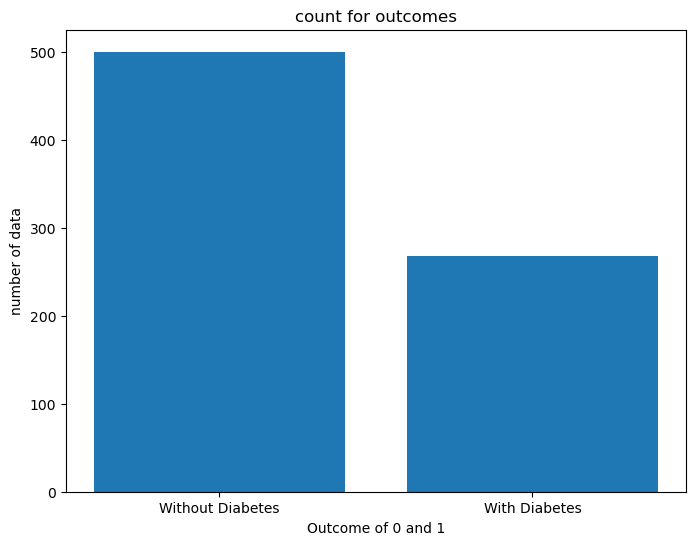

In [16]:
bal_check = df['Outcome'].value_counts()
print(bal_check)
plt.figure(figsize=(8,6))
plt.bar(bal_check.index, bal_check.values)
plt.xlabel('Outcome of 0 and 1')
plt.ylabel('number of data')
plt.xticks(ticks=[0, 1], labels=['Without Diabetes', 'With Diabetes'])
plt.title('count for outcomes')

In [17]:
# Null 값은 없음
# object가 없는거 보면 별도의 피처 인코딩 필요하지 않아보임
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [18]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    
    print('오차행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1스코어: {f1:.4f}, AUC:{auc:.4f}')

In [40]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for x in thresholds:
        print(f'Current threshold: {x}')
        threshold_custom(y_test, pred_proba_c1, x)
        print()

In [52]:
from sklearn.preprocessing import Binarizer
def threshold_custom(y_test, pred_prob, threshold):
    pred_prob_ = pred_prob[:,1].reshape(-1,1)
    binarizer = Binarizer(threshold = threshold)
    
    custom_pred = binarizer.fit_transform(pred_prob_)
    get_clf_eval(y_test, custom_pred, pred_prob_)

In [20]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [19]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926, f1스코어: 0.6465, AUC:0.8083


### 전체 데이터에서 negative의 양이 더 많기에, positive(소수 클래스)를 더 올리기 위해서 재현율 성능을 올리자

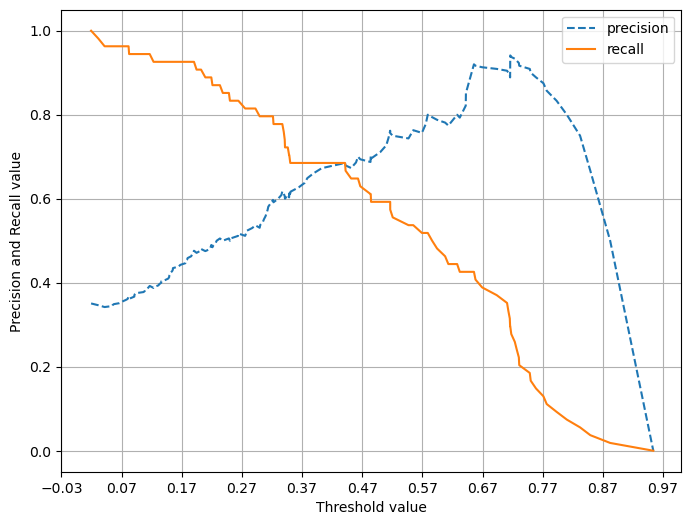

In [21]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

### threshold를 0.42정도로 낮추면 balance 가 맞을거 같다. 하지만, 이 마저도 각각의 값이 0.7 이하로 성능이 좋지가 않다.
다시 데이터를 점검해보자

In [22]:
# min이 0으로 되어있는 경우가 왜이렇게 많을까?
# 특히 glucose, bloodpressure, Insulin 같은 경우에는 0인게 그냥 말이 안되네
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


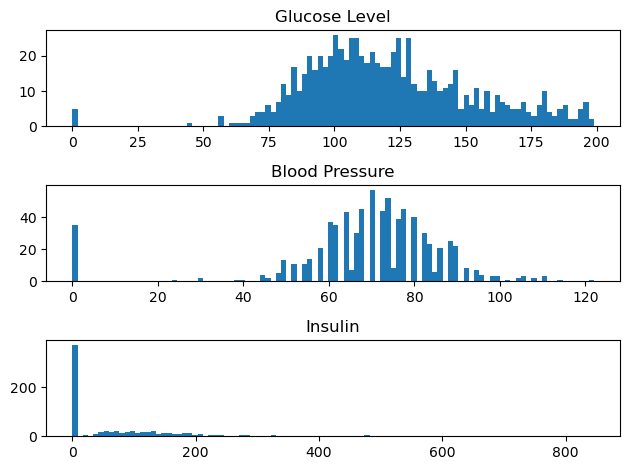

In [28]:
# glucose 확인
plt.subplot(3, 1, 1)
plt.title('Glucose Level')
plt.hist(df['Glucose'], bins=100)

plt.subplot(3, 1, 2)
plt.title('Blood Pressure')
plt.hist(df['BloodPressure'], bins=100)

plt.subplot(3, 1, 3)
plt.title('Insulin')
plt.hist(df['Insulin'], bins=100)

plt.tight_layout()
plt.show()

In [30]:
# min 값 검사
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

total_count = df['Glucose'].count()

for feature in zero_features:
    zero_cnt = df[df[feature] == 0][feature].count()
    print(f'{feature} 건수는 {zero_cnt}, 퍼센트는 {100*zero_cnt/total_count:.2f}%')

Glucose 건수는 5, 퍼센트는 0.65%
BloodPressure 건수는 35, 퍼센트는 4.56%
SkinThickness 건수는 227, 퍼센트는 29.56%
Insulin 건수는 374, 퍼센트는 48.70%
BMI 건수는 11, 퍼센트는 1.43%


In [32]:
# 위에서 보이는 0 값들을 변환해야할거같은데, drop 하기에는 데이터가 아까우니 평균값으로 대체하자
mean_zero = df[zero_features].mean()
df[zero_features] = df[zero_features].replace(0, mean_zero)

In [33]:
# mean 값들 처리된거 확인
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [34]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, f1스코어: 0.6804, AUC:0.8433


In [46]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

parameters_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],  # 규제 강도 더 세분화
    'max_iter': [50, 100, 200, 300, 500, 1000, 2000]           # 최대 반복 횟수 확장
}
grid_lclf = GridSearchCV(lr_clf, param_grid=parameters_lr, scoring='accuracy', cv=5)
grid_lclf.fit(X_train, y_train)
print(f"GridSearchCV 최적 hyperparameter: {grid_lclf.best_params_}")
print(f"GridSearchCV 최고 정확도: {grid_lclf.best_score_:.4f}")
best_lclf = grid_lclf.best_estimator_

pred = best_lclf.predict(X_test)
pred_proba = best_lclf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

GridSearchCV 최적 hyperparameter: {'C': 0.1, 'max_iter': 50}
GridSearchCV 최고 정확도: 0.7687
오차행렬
[[89 11]
 [21 33]]
정확도: 0.7922, 정밀도: 0.7500, 재현율: 0.6111, f1스코어: 0.6735, AUC:0.8456


In [53]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]
pred_proba = best_lclf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba, thresholds)

Current threshold: 0.3
오차행렬
[[64 36]
 [10 44]]
정확도: 0.7013, 정밀도: 0.5500, 재현율: 0.8148, f1스코어: 0.6567, AUC:0.8456

Current threshold: 0.33
오차행렬
[[68 32]
 [11 43]]
정확도: 0.7208, 정밀도: 0.5733, 재현율: 0.7963, f1스코어: 0.6667, AUC:0.8456

Current threshold: 0.36
오차행렬
[[73 27]
 [13 41]]
정확도: 0.7403, 정밀도: 0.6029, 재현율: 0.7593, f1스코어: 0.6721, AUC:0.8456

Current threshold: 0.39
오차행렬
[[75 25]
 [15 39]]
정확도: 0.7403, 정밀도: 0.6094, 재현율: 0.7222, f1스코어: 0.6610, AUC:0.8456

Current threshold: 0.42
오차행렬
[[83 17]
 [17 37]]
정확도: 0.7792, 정밀도: 0.6852, 재현율: 0.6852, f1스코어: 0.6852, AUC:0.8456

Current threshold: 0.45
오차행렬
[[85 15]
 [19 35]]
정확도: 0.7792, 정밀도: 0.7000, 재현율: 0.6481, f1스코어: 0.6731, AUC:0.8456

Current threshold: 0.48
오차행렬
[[89 11]
 [20 34]]
정확도: 0.7987, 정밀도: 0.7556, 재현율: 0.6296, f1스코어: 0.6869, AUC:0.8456

Current threshold: 0.5
오차행렬
[[89 11]
 [21 33]]
정확도: 0.7922, 정밀도: 0.7500, 재현율: 0.6111, f1스코어: 0.6735, AUC:0.8456



In [56]:
# f1 score 제일 높은게 0.48 threshold
# 이 threshold 적용하기 위해 binarizer 사용

binarizer = Binarizer(threshold=0.48)
pred_th = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
get_clf_eval(y_test, pred_th, pred_proba[:, 1])

오차행렬
[[89 11]
 [20 34]]
정확도: 0.7987, 정밀도: 0.7556, 재현율: 0.6296, f1스코어: 0.6869, AUC:0.8456


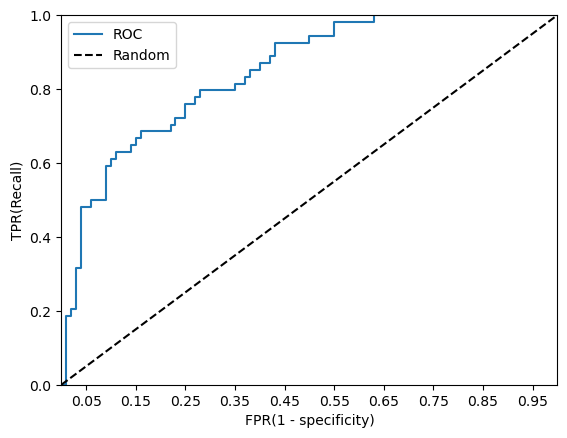

In [59]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - specificity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
fprs, tprs, thresholds = roc_curve(y_test, pred_proba[:,1])
roc_curve_plot(y_test, pred_proba[:,1])